# 4) Analysis Layer (Spark)

Hier werden nun die Analysen durchgeführt, also einerseits Plots, die Korrelationen veranschaulichen und andererseits die Modelle: Regression (Dauer) & Klassifikation (Schweregrad der Verspätung)


In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except ImportError:
    sns = None

from pyspark.sql import SparkSession, functions as F, Window
#damit im Terminal erkannt wird, wann man sich die Datarfames anschaut
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


In [2]:
#Spark Session wird gestartet - Verbindung mit dem Master
SPARK_MASTER = os.getenv("SPARK_MASTER", "spark://spark-master:7077")
APP_NAME = os.getenv("SPARK_APP_NAME", "WeatherAndDelayAnalysis")

spark = (
    SparkSession.builder
    .appName(APP_NAME)
    .master(SPARK_MASTER)
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")

print("Spark master:", spark.sparkContext.master)
print("Spark app:", spark.sparkContext.appName)


Spark master: spark://spark-master:7077
Spark app: WeatherAndDelayAnalysis


In [3]:
#Daten aus MongoDB holen
from pymongo import MongoClient

MONGO_URI = os.getenv("MONGO_URI", "mongodb://mongodb:27017")
DB_NAME = os.getenv("MONGO_DB", "big_data_austria")
CLEANED_COLLECTION = os.getenv("CLEANED_COLLECTION", "wienerlinien_hw25_merged")

client = MongoClient(MONGO_URI)
db = client[DB_NAME]

#bereinigte Daten werden in Spark dfs umgewandelt
cleaned_docs = list(db[CLEANED_COLLECTION].find({}, {"_id": 0}))
if not cleaned_docs:
    raise ValueError(f"No documents found in {CLEANED_COLLECTION}")

spark_cleaned = spark.createDataFrame(cleaned_docs)
spark_cleaned = (
    spark_cleaned
    .withColumn("start_time", F.col("start_time").cast("timestamp"))
    .withColumn("end_time", F.col("end_time").cast("timestamp"))
)
spark_cleaned = spark_cleaned.filter(F.col("start_time").isNotNull())

#Wetterspalten identifizieren, in Double umwandeln für Rechnungen
weather_cols = [c for c in ["RR", "TL", "P", "FF", "SO", "S0", "RF", "station_id"] if c in spark_cleaned.columns]
numeric_weather_cols = [c for c in weather_cols if c != "station_id"]
for col in numeric_weather_cols:
    spark_cleaned = spark_cleaned.withColumn(col, F.col(col).cast("double"))

print("Loaded cleaned rows:", spark_cleaned.count())
spark_cleaned.select("start_time", "end_time", *weather_cols).show(5, truncate=False)

#auf Tagesbasis
agg_exprs = [F.count(F.lit(1)).alias("delay_count")]
agg_exprs += [F.avg(F.col(c)).alias(c) for c in numeric_weather_cols]
if "station_id" in spark_cleaned.columns:
    agg_exprs.append(F.first("station_id").alias("station_id"))

spark_daily = (
    spark_cleaned
    .withColumn("date", F.to_date("start_time"))
    .groupBy("date")
    .agg(*agg_exprs)
    .orderBy("date")
)

spark_daily.show(5, truncate=False)


Loaded cleaned rows: 1347
+-------------------+-------------------+---+---+-----+---+---+----+----------+
|start_time         |end_time           |RR |TL |P    |FF |SO |RF  |station_id|
+-------------------+-------------------+---+---+-----+---+---+----+----------+
|2025-11-29 23:00:17|2025-12-02 22:59:59|0.0|3.0|990.0|0.9|0.0|80.0|HW_25     |
|2025-11-30 23:00:17|2025-12-02 22:59:59|0.0|2.6|992.2|1.0|0.0|98.0|HW_25     |
|2025-11-30 23:00:17|2025-12-03 22:59:59|0.0|2.6|992.2|1.0|0.0|98.0|HW_25     |
|2025-11-30 23:00:18|2025-12-02 22:59:59|0.0|2.6|992.2|1.0|0.0|98.0|HW_25     |
|2025-11-30 23:00:18|2025-12-03 22:59:59|0.0|2.6|992.2|1.0|0.0|98.0|HW_25     |
+-------------------+-------------------+---+---+-----+---+---+----+----------+
only showing top 5 rows

+----------+-----------+------------------+------------------+-----------------+------------------+---+-----------------+----------+
|date      |delay_count|RR                |TL                |P                |FF              

## Delay-Weather Relationship (Spark)


corr(delay_count, RR) = 0.211


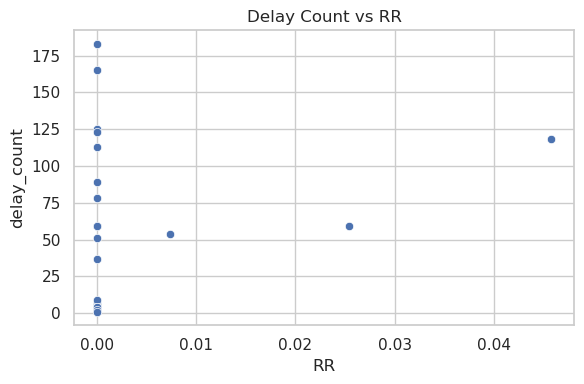

corr(delay_count, FF) = -0.242


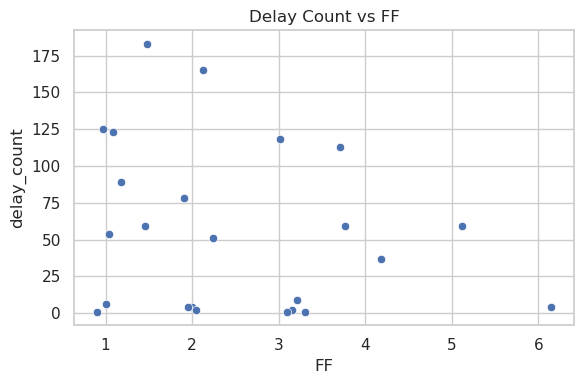

corr(delay_count, TL) = 0.424


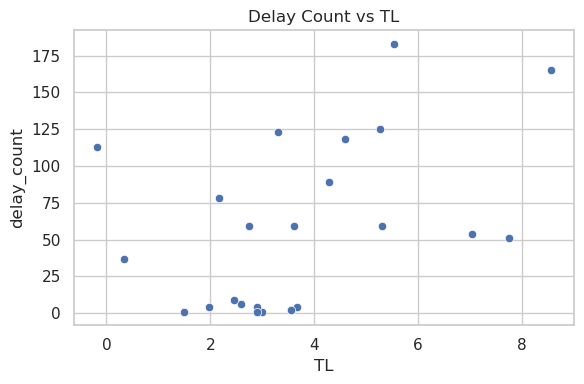

In [4]:
#Korrelation zwischen Regen, Wind, Temperatur und Wetter
for col in ["RR", "FF", "TL"]:
    if col in spark_daily.columns:
        corr = spark_daily.stat.corr("delay_count", col)
        print(f"corr(delay_count, {col}) = {corr:.3f}")

        plot_df = spark_daily.select("delay_count", col).dropna().toPandas()
        if not plot_df.empty:
            plt.figure(figsize=(6, 4))
            if sns is not None:
                sns.scatterplot(data=plot_df, x=col, y="delay_count")
            else:
                plt.scatter(plot_df[col], plot_df["delay_count"], alpha=0.6)
                plt.xlabel(col)
                plt.ylabel("delay_count")
            plt.title(f"Delay Count vs {col}")
            plt.tight_layout()
            plt.show()
    else:
        print(f"{col} column not found in spark_daily.")


+---------+------------------+------------------+----+
|rainy_day|avg_delay_count   |median_delay_count|days|
+---------+------------------+------------------+----+
|false    |53.142857142857146|37                |21  |
|true     |77.0              |59                |3   |
+---------+------------------+------------------+----+



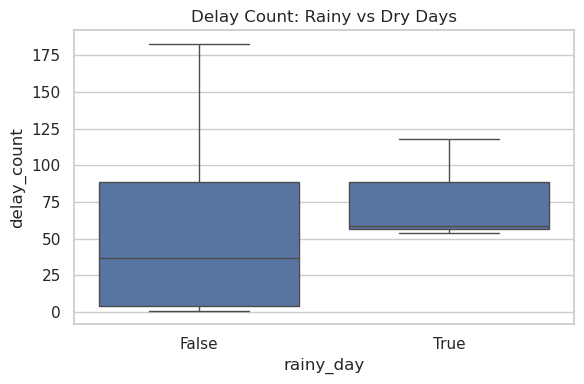

In [5]:
#Regen-Check
if "RR" in spark_daily.columns:
    spark_daily_rain = spark_daily.withColumn("rainy_day", F.col("RR") > 0)
    rain_summary = (
        spark_daily_rain
        .groupBy("rainy_day")
        .agg(
            F.avg("delay_count").alias("avg_delay_count"),
            F.expr("percentile_approx(delay_count, 0.5)").alias("median_delay_count"),
            F.count(F.lit(1)).alias("days")
        )
        .orderBy("rainy_day")
    )
    rain_summary.show(truncate=False)
#Boxplot für den Regenvergleich
    plot_df = spark_daily_rain.select("rainy_day", "delay_count").toPandas()
    if not plot_df.empty:
        plt.figure(figsize=(6, 4))
        if sns is not None:
            sns.boxplot(data=plot_df, x="rainy_day", y="delay_count")
        else:
            groups = [
                plot_df.loc[plot_df["rainy_day"], "delay_count"].dropna(),
                plot_df.loc[~plot_df["rainy_day"], "delay_count"].dropna(),
            ]
            plt.boxplot(groups, labels=["rainy", "dry"])
            plt.ylabel("delay_count")
        plt.title("Delay Count: Rainy vs Dry Days")
        plt.tight_layout()
        plt.show()
else:
    print("RR column not found; skipping rainy vs dry boxplot.")


## Time Series Analytics (Spark)


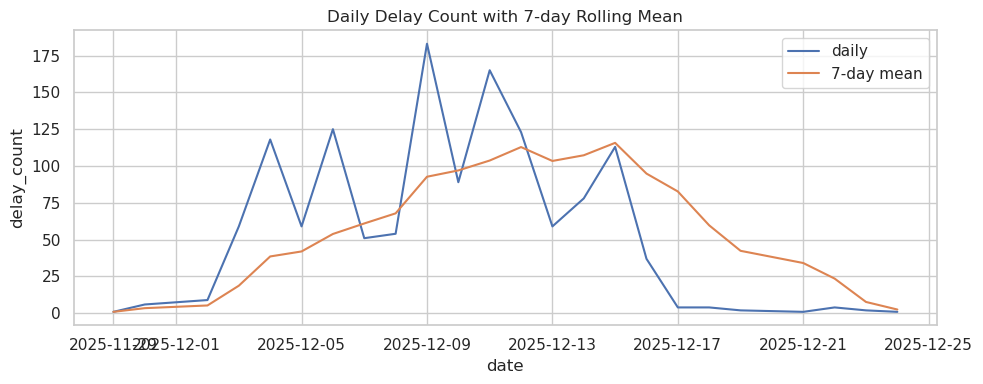

+-----------+-------+------------------+
|weekday_num|weekday|avg_delay_count   |
+-----------+-------+------------------+
|1          |Mon    |57.0              |
|2          |Tue    |57.75             |
|3          |Wed    |38.25             |
|4          |Thu    |95.66666666666667 |
|5          |Fri    |61.333333333333336|
|6          |Sat    |61.666666666666664|
|7          |Sun    |34.0              |
+-----------+-------+------------------+



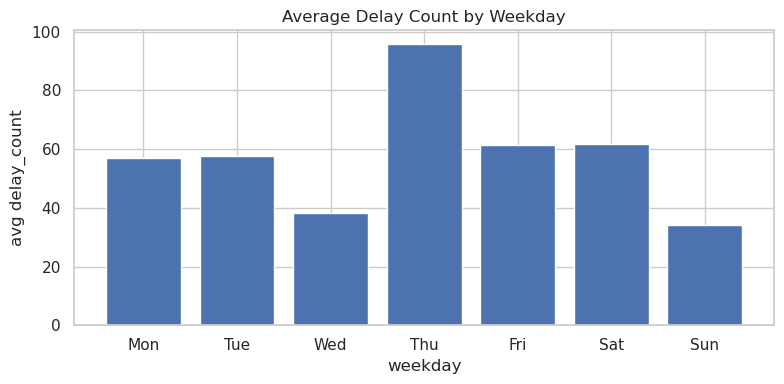

+----------+-----------+---+-----------------+-----------------+-----------------+---+-----------------+
|date      |delay_count|RR |TL               |P                |FF               |SO |RF               |
+----------+-----------+---+-----------------+-----------------+-----------------+---+-----------------+
|2025-12-09|183        |0.0|5.542076502732236|995.4814207650253|1.479781420765027|0.0|98.24043715846994|
+----------+-----------+---+-----------------+-----------------+-----------------+---+-----------------+



In [6]:
#Gleitender Durchschnitt über 7 Tage, um noise wegzubekommen
window_7 = Window.orderBy("date").rowsBetween(-6, 0)
spark_daily_ts = spark_daily.withColumn("rolling_7d", F.avg("delay_count").over(window_7))

plot_df = spark_daily_ts.select("date", "delay_count", "rolling_7d").toPandas()
if not plot_df.empty:
    plt.figure(figsize=(10, 4))
    plt.plot(plot_df["date"], plot_df["delay_count"], label="daily")
    plt.plot(plot_df["date"], plot_df["rolling_7d"], label="7-day mean")
    plt.title("Daily Delay Count with 7-day Rolling Mean")
    plt.xlabel("date")
    plt.ylabel("delay_count")
    plt.legend()
    plt.tight_layout()
    plt.show()

#Wochentags-Check: Mo-So im Vergleich
weekday_summary = (
    spark_daily_ts
    .withColumn("weekday_num", F.when(F.dayofweek("date") == 1, 7).otherwise(F.dayofweek("date") - 1))
    .withColumn("weekday", F.date_format("date", "E"))
    .groupBy("weekday_num", "weekday")
    .agg(F.avg("delay_count").alias("avg_delay_count"))
    .orderBy("weekday_num")
)
weekday_summary.show(truncate=False)

weekday_df = weekday_summary.toPandas()
if not weekday_df.empty:
    plt.figure(figsize=(8, 4))
    plt.bar(weekday_df["weekday"], weekday_df["avg_delay_count"])
    plt.title("Average Delay Count by Weekday")
    plt.xlabel("weekday")
    plt.ylabel("avg delay_count")
    plt.tight_layout()
    plt.show()
#chaotischsten Tage
threshold = spark_daily_ts.approxQuantile("delay_count", [0.99], 0.01)[0]
event_days = spark_daily_ts.filter(F.col("delay_count") >= threshold)
display_cols = ["date", "delay_count"] + [c for c in ["RR", "TL", "P", "FF", "SO", "S0", "RF"] if c in spark_daily_ts.columns]
event_days.select(*display_cols).orderBy(F.col("delay_count").desc()).show(10, truncate=False)


## Duration Analysis (Spark)


+-----------------+-----------------+----+
|avg_min          |median_min       |rows|
+-----------------+-----------------+----+
|338.6872185102698|59.06666666666667|1347|
+-----------------+-----------------+----+



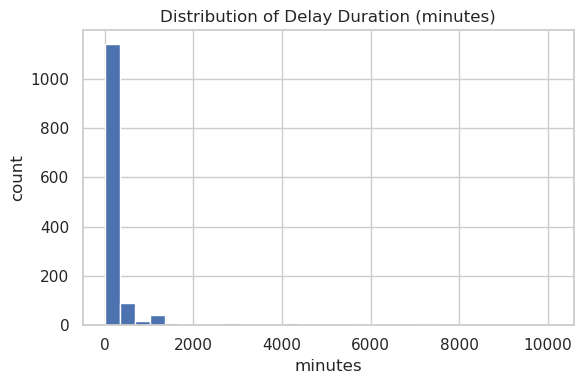

+--------+-----------------+-----------------+----+
|wind_bin|avg_min          |median_min       |rows|
+--------+-----------------+-----------------+----+
|wind<=10|338.6872185102698|59.06666666666667|1347|
+--------+-----------------+-----------------+----+



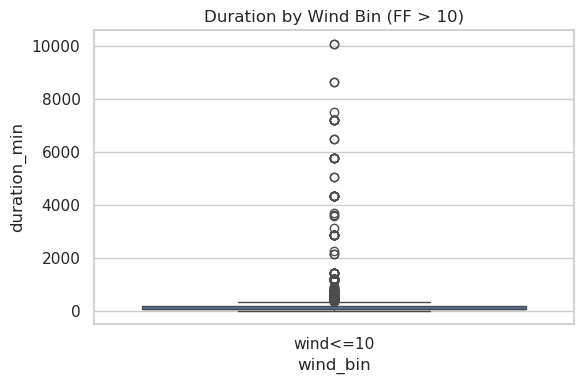

In [7]:
dur = (
    spark_cleaned
    .withColumn("duration_min", (F.col("end_time").cast("long") - F.col("start_time").cast("long")) / 60.0)
    .filter(F.col("duration_min") >= 0)
)

dur.select(
    F.avg("duration_min").alias("avg_min"),
    F.expr("percentile_approx(duration_min, 0.5)").alias("median_min"),
    F.count(F.lit(1)).alias("rows")
).show(truncate=False)

plot_df = dur.select("duration_min").toPandas()
if not plot_df.empty:
    plt.figure(figsize=(6, 4))
    plt.hist(plot_df["duration_min"].dropna(), bins=30)
    plt.title("Distribution of Delay Duration (minutes)")
    plt.xlabel("minutes")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

if "FF" in dur.columns:
    dur_bins = (
        dur
        .withColumn("wind_bin", F.when(F.col("FF") > 10, F.lit("wind>10")).otherwise(F.lit("wind<=10")))
    )
    dur_bins.groupBy("wind_bin").agg(
        F.avg("duration_min").alias("avg_min"),
        F.expr("percentile_approx(duration_min, 0.5)").alias("median_min"),
        F.count(F.lit(1)).alias("rows")
    ).show(truncate=False)

    plot_df = dur_bins.select("wind_bin", "duration_min").toPandas()
    if not plot_df.empty:
        plt.figure(figsize=(6, 4))
        if sns is not None:
            sns.boxplot(data=plot_df, x="wind_bin", y="duration_min")
        else:
            groups = [
                plot_df.loc[plot_df["wind_bin"] == "wind>10", "duration_min"].dropna(),
                plot_df.loc[plot_df["wind_bin"] == "wind<=10", "duration_min"].dropna(),
            ]
            plt.boxplot(groups, labels=["wind>10", "wind<=10"])
            plt.ylabel("duration_min")
        plt.title("Duration by Wind Bin (FF > 10)")
        plt.tight_layout()
        plt.show()
else:
    print("FF column not found; skipping wind bin analysis.")


## Predictive Model (Spark ML)


In [8]:
try:
    from pyspark.ml import Pipeline
    from pyspark.ml.classification import LogisticRegression
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    from pyspark.ml.feature import Imputer, StandardScaler, VectorAssembler

#Features vorbereiten
    feature_cols = [c for c in ["RR", "TL", "P", "FF", "SO", "S0", "RF"] if c in spark_daily.columns]
    if not feature_cols:
        raise ValueError("No feature columns available for Spark model.")
#high delay?
    model_df = spark_daily.select("date", "delay_count", *feature_cols).dropna(subset=["delay_count"])
    threshold = model_df.approxQuantile("delay_count", [0.90], 0.01)[0]
    model_df = model_df.withColumn("label", (F.col("delay_count") >= threshold).cast("int"))
#train test / split (80/20)
    window = Window.orderBy("date")
    model_df = model_df.withColumn("rn", F.row_number().over(window))
    total = model_df.count()
    split_idx = int(total * 0.8)
    train = model_df.filter(F.col("rn") <= split_idx)
    test = model_df.filter(F.col("rn") > split_idx)

    print("Train class balance:")
    train.groupBy("label").count().show()
    print("Test class balance:")
    test.groupBy("label").count().show()
# ML Pipeline: Fehlende Werte füllen -> Vektorisieren -> Skalieren -> Logistische Regression
    imputer = Imputer(inputCols=feature_cols, outputCols=[f"{c}_imp" for c in feature_cols])
    assembler = VectorAssembler(inputCols=[f"{c}_imp" for c in feature_cols], outputCol="features_raw")
    scaler = StandardScaler(inputCol="features_raw", outputCol="features")
    lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)

    pipeline = Pipeline(stages=[imputer, assembler, scaler, lr])
    model = pipeline.fit(train)
    preds = model.transform(test)
#AUC score
    evaluator = BinaryClassificationEvaluator(labelCol="label")
    auc = evaluator.evaluate(preds)
    print("Spark AUC:", auc)
    preds.groupBy("label", "prediction").count().show()

except Exception as exc:
    print("Spark ML model skipped:", exc)


Train class balance:
+-----+-----+
|label|count|
+-----+-----+
|    0|   16|
|    1|    3|
+-----+-----+

Test class balance:
+-----+-----+
|label|count|
+-----+-----+
|    0|    5|
+-----+-----+

Spark AUC: 0.0
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|    5|
+-----+----------+-----+



## Text Analytics (Spark)


In [9]:
import json
from pymongo import MongoClient
from pyspark.sql import types as T

MONGO_URI = os.getenv("MONGO_URI", "mongodb://mongodb:27017")
DB_NAME = os.getenv("MONGO_DB", "big_data_austria")
WL_COLLECTION = os.getenv("WL_HIST_COLLECTION", "wienerlinien_historical")
HW_COLLECTION = os.getenv("HW_COLLECTION", "Station_HW_25")

client = MongoClient(MONGO_URI)
db = client[DB_NAME]

wl_docs = list(db[WL_COLLECTION].find({}, {
    "_id": 0,
    "PartitionKey": 1,
    "category": 1,
    "data": 1,
    "time_start": 1,
    "timestart": 1,
    "title": 1,
    "description": 1,
}))
hw_docs = list(db[HW_COLLECTION].find({}, {"_id": 0}))

if not wl_docs:
    raise ValueError("No Wiener Linien docs found for text analytics.")
if not hw_docs:
    raise ValueError("No HW 25 docs found for text analytics.")

wl_raw = spark.createDataFrame(wl_docs)
hw_raw = spark.createDataFrame(hw_docs)

wl = wl_raw
if "PartitionKey" in wl.columns:
    wl = wl.filter(F.lower(F.coalesce(F.col("PartitionKey"), F.lit(""))) != "stoerunglang")
if "category" in wl.columns:
    wl = wl.filter(F.lower(F.coalesce(F.col("category"), F.lit(""))) != "stoerunglang")

if "data" in wl.columns:
    data_type = wl_raw.schema["data"].dataType
    if isinstance(data_type, T.StringType):
        data_json = F.col("data")
    else:
        data_json = F.to_json(F.col("data"))
    wl = wl.withColumn("data_title", F.get_json_object(data_json, "$.title"))
    wl = wl.withColumn("data_description", F.get_json_object(data_json, "$.description"))
    wl = wl.withColumn("data_time_start", F.get_json_object(data_json, "$.time.start"))
else:
    wl = wl.withColumn("data_title", F.lit(None))
    wl = wl.withColumn("data_description", F.lit(None))
    wl = wl.withColumn("data_time_start", F.lit(None))

time_cols = [c for c in ["time_start", "timestart", "data_time_start"] if c in wl.columns]
if not time_cols:
    raise ValueError("No time columns found for text analytics.")
time_start_expr = F.coalesce(*[F.col(c) for c in time_cols])

wl = wl.withColumn("time_start_raw", time_start_expr)
wl = wl.withColumn("timestamp", F.to_timestamp(F.col("time_start_raw"), "yyyy-MM-dd'T'HH:mm:ss.SSSZ"))
wl = wl.withColumn("timestamp", F.coalesce(F.col("timestamp"), F.to_timestamp(F.col("time_start_raw"))))
wl = wl.filter(F.col("timestamp").isNotNull())
wl = wl.withColumn("wl_id", F.monotonically_increasing_id())

hw = hw_raw
if "timestamp" not in hw.columns:
    raise ValueError("HW 25 data has no 'timestamp' column.")

hw = hw.withColumn("timestamp", F.to_timestamp(F.col("timestamp")))
hw = hw.filter(F.col("timestamp").isNotNull())
for col in ["RR", "TL", "P", "FF", "SO", "S0", "RF"]:
    if col in hw.columns:
        hw = hw.withColumn(col, F.col(col).cast("double"))

wl_alias = wl.alias("wl")
hw_alias = hw.alias("hw")
joined = wl_alias.join(hw_alias, F.col("hw.timestamp") <= F.col("wl.timestamp"), "left")
window = Window.partitionBy("wl_id").orderBy(F.col("hw.timestamp").desc())
joined = joined.withColumn("rn", F.row_number().over(window)).filter(F.col("rn") == 1)

title_cols = [c for c in ["title", "data_title"] if c in joined.columns]
if not title_cols:
    raise ValueError("No title columns available for keyword extraction.")
title_expr = F.coalesce(*[F.col(c) for c in title_cols], F.lit(""))
title_norm = F.lower(title_expr)
joined = joined.withColumn("title_norm", title_norm)

text_cols = [c for c in ["description", "data_description", "title", "data_title"] if c in joined.columns]
if text_cols:
    text_expr = F.coalesce(*[F.col(c) for c in text_cols], F.lit(""))
else:
    text_expr = F.lit("")
text_norm = F.lower(text_expr)
joined = joined.withColumn("text", text_norm)

reason_keywords = [
    "fahrtbehinderung",
    "bauarbeiten",
    "falschparker",
    "rettungseinsatz",
    "schadhafter zug",
    "umleitung",
    "umeltung",
    "signalstoerung",
    "stoerung",
    "unfall",
    "polizei",
    "defekt",
]

reason_array = F.flatten(F.array(*[
    F.when(F.instr(F.col("title_norm"), kw) > 0, F.array(F.lit(kw))).otherwise(F.array())
    for kw in reason_keywords
]))

reason_hits = joined.select(F.explode(reason_array).alias("reason"))
reason_counts = (
    reason_hits
    .groupBy("reason")
    .count()
    .orderBy(F.desc("count"))
)
reason_counts.show(10, truncate=False)

reason_primary = F.regexp_extract(F.col("title_norm"), r"^[a-z0-9]+", 0)
fallback_counts = (
    joined
    .withColumn("reason_primary", reason_primary)
    .groupBy("reason_primary")
    .count()
    .orderBy(F.desc("count"))
)
fallback_counts.show(10, truncate=False)


+----------------+-----+
|reason          |count|
+----------------+-----+
|fahrtbehinderung|5560 |
|unfall          |2143 |
|rettungseinsatz |2023 |
|falschparker    |1276 |
|schadhafter zug |712  |
|polizei         |637  |
|bauarbeiten     |586  |
|umleitung       |266  |
|umeltung        |5    |
+----------------+-----+

+----------------+-----+
|reason_primary  |count|
+----------------+-----+
|fahrtbehinderung|5558 |
|endstation      |1875 |
|rettungseinsatz |876  |
|verkehrsunfall  |499  |
|gleisschaden    |402  |
|gleisbauarbeiten|366  |
|schadhafter     |336  |
|                |280  |
|falschparker    |263  |
|demonstration   |258  |
+----------------+-----+
only showing top 10 rows

